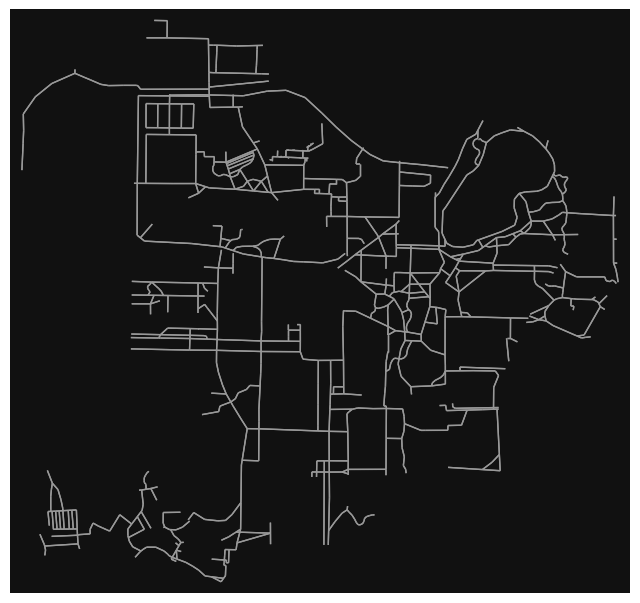

,y,x,street_count,highway,geometry
osmid,,,,,
334549768,24.790392,120.995609,2,NaN,POINT (120.99561 24.79039)
1372433722,24.788580,120.993844,1,NaN,POINT (120.99384 24.78858)
1463796822,24.784098,120.996504,1,NaN,POINT (120.99650 24.78410)
1463796823,24.788643,120.997083,3,NaN,POINT (120.99708 24.78864)
1463798922,24.784614,120.997946,2,NaN,POINT (120.99795 24.78461)


In [113]:
import osmnx as ox
import networkx as nx
import math
import matplotlib as plt


place = "National Chiao Tung University, Hsinchu"
# Download the street network graph for the area
G = ox.load_graphml('NYCU.graphml')

fig, ax = ox.plot_graph(G, node_size=0)
fig.savefig("route_plot.png", dpi=300, bbox_inches='tight')
# Get edge geometries for the route
nodes, edges = ox.graph_to_gdfs(G)
nodes.head()

In [108]:
new_nodes = [(24.789487, 120.995819, 3), (24.789492, 120.996233, 2), (24.789480, 120.996797, 3), 
             (24.789536, 120.997117, 3), (24.789546, 120.997367, 2), (24.789458, 120.997621, 3),
             (24.789269, 120.997846, 2), (24.789100, 120.998036, 3), (24.788939, 120.998236, 2),
             (24.788769, 120.998487, 3), (24.788691, 120.998663, 2), (24.788670, 120.998876, 3),
             (24.788646, 120.999165, 2), (24.7886090, 120.999528, 3)]  # List of new nodes

# Add new nodes to the graph
new_node_ids = []
for i, (lat, lon, sc) in enumerate(new_nodes):
    new_node_id = max(G.nodes) + 1 + i  # Generate unique node IDs
    G.add_node(new_node_id, y=lat, x=lon, street_count=sc)  # Add node to the graph
    new_node_ids.append(new_node_id)  # Store the node IDs for later use

# Connect the new nodes to each other
for i in range(len(new_node_ids) - 1):
    node1 = new_node_ids[i]
    node2 = new_node_ids[i + 1]
    
    # Calculate an example length for the edge, or use some actual distance
    G.add_edge(node1, node2, length=100)  # Add edge from node1 to node2
    G.add_edge(node2, node1, length=100)  # Add edge from node2 to node1 (bidirectional)

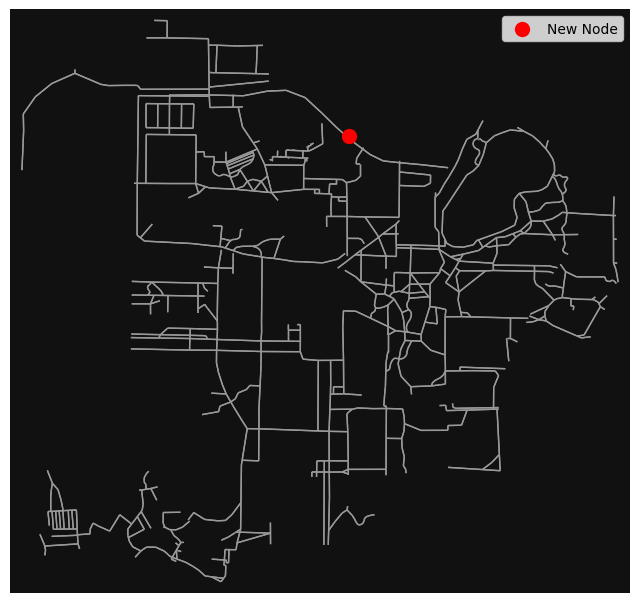

In [109]:
import osmnx as ox
import matplotlib.pyplot as plt

# Assuming you have already added the node to the graph 'G'
# Plot the original graph (without newly added nodes)
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)

# Manually plot the new node using its coordinates
for node_id in G.nodes:
    if G.nodes[node_id]['x'] == 120.999505 and G.nodes[node_id]['y'] == 24.788769:
        ax.scatter(G.nodes[node_id]['x'], G.nodes[node_id]['y'], color="red", s=100, zorder=5, label="New Node")
        
ax.scatter(120.998200, 24.788988, color="red", s=100, zorder=5, label="New Node")
# Show the updated plot with the new node
plt.legend()
plt.show()


In [110]:
ox.save_graphml(G, filepath="NYUC.graphml")

In [2]:
import pandas as pd 

bf = pd.read_csv('building_feature.csv')

bf.loc[bf['name'] == '羽球館']['description'][0]

'有年代的建築'

In [33]:

# Function to calculate angle between two vectors (for turning detection)
def calculate_angle(p1, p2, p3):
    v1 = (p2[0] - p1[0], p2[1] - p1[1])
    v2 = (p3[0] - p2[0], p3[1] - p2[1])
    angle = math.degrees(math.atan2(v2[1], v2[0]) - math.atan2(v1[1], v1[0]))
    angle = (angle + 360) % 360  # Normalize to 0-360 degrees
    return angle

# Get node degrees to find intersections
node_degrees = dict(G.degree())
intersections = [node for node, degree in node_degrees.items() if degree >= 3]

# List to hold turn-by-turn instructions and turn locations
turn_instructions = []
turn_spots = []  # For storing coordinates of the turns for plotting
turn_spots_osmid = []
# Iterate through the route, looking for turns only at intersections
for i in range(1, len(route) - 1):
    if route[i] in intersections:  # Only process if the current node is an intersection
        p1 = (G.nodes[route[i - 1]]['y'], G.nodes[route[i - 1]]['x'])
        p2 = (G.nodes[route[i]]['y'], G.nodes[route[i]]['x'])
        p3 = (G.nodes[route[i + 1]]['y'], G.nodes[route[i + 1]]['x'])
        
        angle = calculate_angle(p1, p2, p3)
        
        if 45 < angle < 135:  # Right turn
            turn_instructions.append(f"Turn right at intersection {route[i]}")
            turn_spots.append((p2[0], p2[1]))
            turn_spots_osmid.append(route[i])
        elif 225 < angle < 315:  # Left turn
            turn_instructions.append(f"Turn left at intersection {route[i]}")
            turn_spots.append((p2[0], p2[1]))
            turn_spots_osmid.append(route[i])

# Plot the entire route
fig, ax = ox.plot_graph_route(G, route, route_linewidth=3, node_size=0, bgcolor='white', show=False)

# Plot the intersections where instructions are given
turn_xs = [x for y, x in turn_spots]
turn_ys = [y for y, x in turn_spots]
ax.scatter(turn_xs, turn_ys, c='red', s=100, label='Turn Instructions', zorder=5)


print(type(turn_spots_osmid[0]))
# Print turn instructions
for instruction in turn_instructions:
    print(instruction)


<class 'int'>
Turn right at intersection 2129174836
Turn right at intersection 2773378905
Turn left at intersection 2773378899
Turn right at intersection 2130856065
Turn left at intersection 1463796823
Turn right at intersection 2130856080
Turn left at intersection 2130856134
Turn right at intersection 2130856014
Turn left at intersection 2631338175
Turn right at intersection 2631338174
Turn left at intersection 2811520849


In [1]:
bf = pd.read_csv('building_feature.csv')
bf.loc[bf['name'] == info]

NameError: name 'pd' is not defined

In [31]:
import geopandas as gpd
from shapely.geometry import Point

# Assuming gdf_filtered is a GeoDataFrame containing the buildings with their geometries
# Ensure the CRS of the buildings matches the graph (usually it's EPSG:4326 for OSM data)
gdf_filtered = gdf_filtered.to_crs(epsg=4326)
print(turn_spots)
for spots in turn_spots:
    # Create a GeoDataFrame from the intersections
    intersection_points = [Point(x, y) for y, x in [spots]]  # Create Point geometries for intersections
    gdf_intersections = gpd.GeoDataFrame(geometry=intersection_points, crs="EPSG:4326")
    
    # Perform a spatial join to find nearest buildings within a certain distance (e.g., 50 meters)
    # buffer() creates a radius around the intersection points
    buffered_intersections = gdf_intersections.copy()
    buffered_intersections['geometry'] = buffered_intersections.geometry.buffer(0.0003)  # Approx. 50 meters in degrees
    
    # Find buildings that intersect with these buffered areas (i.e., within 50 meters)
    nearby_buildings = gpd.sjoin(gdf_filtered, buffered_intersections, how='inner', predicate='intersects')
    print(list(nearby_buildings['name']))

[(24.7897519, 120.9945504), (24.7895603, 120.99634), (24.7894738, 120.9963434), (24.7893429, 120.9967289), (24.7886433, 120.9970833), (24.7886378, 120.997603), (24.7884783, 120.9976017), (24.7884273, 120.998173), (24.7880185, 120.9981811), (24.7880133, 120.9984195), (24.7877666, 120.9986019)]
['綜合球館']
['學生九舍', '游泳館']
['科學二館', '學生九舍', '游泳館']
['科學二館', '第二餐廳']
['工程二館']
['工程一館', '工程二館']
['工程一館', '工程二館']
['中正堂', '工程一館']
['中正堂', '資訊技術服務中心']
['中正堂', '資訊技術服務中心']
['人社一館', '行政大樓']


/tmp/ipykernel_152559/2269731278.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_intersections['geometry'] = buffered_intersections.geometry.buffer(0.0003)  # Approx. 50 meters in degrees
/tmp/ipykernel_152559/2269731278.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_intersections['geometry'] = buffered_intersections.geometry.buffer(0.0003)  # Approx. 50 meters in degrees
/tmp/ipykernel_152559/2269731278.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_intersections['geometry'] = buffered_intersections.geometry.buffer(0.0003)  # Approx

In [61]:
def search_the_osmid(key):
    search_result = gdf_filtered.loc[gdf_filtered['name']==key]
    if search_result.empty:
        return  None
    else:
        geo = search_result['geometry']
        result_coord = list(geo.exterior.iloc[0].coords)[0]
        print(result_coord)
        return ox.distance.nearest_nodes(G, X=result_coord[0], Y=result_coord[1])
    
search_the_osmid('工程二館')
search_the_osmid('游泳館')


(120.9976619, 24.7886635)
(120.9954859, 24.7897088)


2714030937

(120.9976619, 24.7886635)
(120.9973627, 24.7893846)


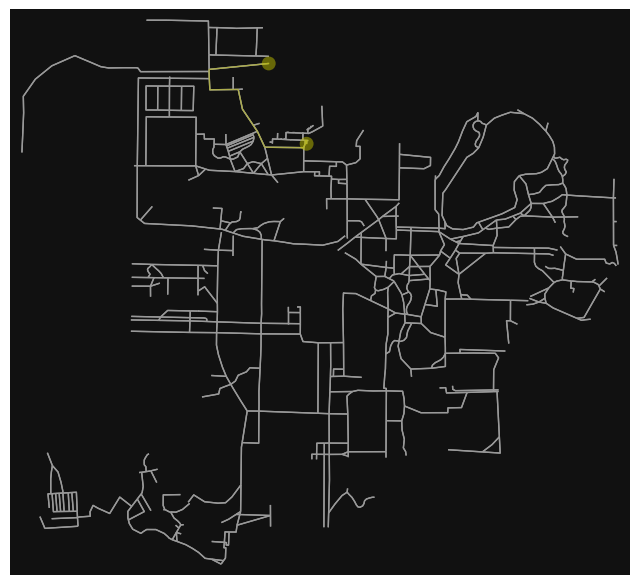

In [66]:
route = ox.shortest_path(G, search_the_osmid('工程二館'), search_the_osmid('第二餐廳'), weight="length")
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=1, node_size=0)
fig.savefig("route_plot.png", dpi=300, bbox_inches='tight')

In [34]:
from .intruction import Instructor



/tmp/ipykernel_152559/3180812581.py:1: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  from .intruction import Instructor


ImportError: attempted relative import with no known parent package

In [41]:

# Function to calculate angle between two vectors (for turning detection)
def calculate_angle(p1, p2, p3):
    v1 = (p2[0] - p1[0], p2[1] - p1[1])
    v2 = (p3[0] - p2[0], p3[1] - p2[1])
    angle = math.degrees(math.atan2(v2[1], v2[0]) - math.atan2(v1[1], v1[0]))
    angle = (angle + 360) % 360  # Normalize to 0-360 degrees
    return angle

# Get node degrees to find intersections
node_degrees = dict(G.degree())

# Filter out only intersections (nodes with degree >= 3)
intersections = [node for node, degree in node_degrees.items() if degree >= 3]

# List to hold turn-by-turn instructions
turn_instructions = []

# Iterate through the route, looking for turns only at intersections
for i in range(1, len(route) - 1):
    # Only process if the current node is an intersection
    if route[i] in intersections:
        p1 = (G.nodes[route[i - 1]]['y'], G.nodes[route[i - 1]]['x'])
        p2 = (G.nodes[route[i]]['y'], G.nodes[route[i]]['x'])
        p3 = (G.nodes[route[i + 1]]['y'], G.nodes[route[i + 1]]['x'])
        
        # Calculate the angle between consecutive segments
        angle = calculate_angle(p1, p2, p3)
        
        # Determine if it's a significant turn (45 < angle < 135 for right, 225 < angle < 315 for left)
        if 45 < angle < 135:
            # Get street names for better instruction
            u, v = route[i], route[i + 1]
            edge_data = G.get_edge_data(u, v, 0)
            street_name = edge_data.get('name', 'Unnamed Road')
            turn_instructions.append(f"Turn right onto {street_name} at node {route[i]}")
        elif 225 < angle < 315:
            u, v = route[i], route[i + 1]
            edge_data = G.get_edge_data(u, v, 0)
            street_name = edge_data.get('name', 'Unnamed Road')
            turn_instructions.append(f"Turn left onto {street_name} at node {route[i]}")

# Display the filtered turn instructions
for instruction in turn_instructions:
    print(instruction)


Turn right onto Unnamed Road at node 2129174836
Turn right onto Unnamed Road at node 2773378905
Turn left onto Unnamed Road at node 2773378899
Turn right onto Unnamed Road at node 2130856065
Turn left onto Unnamed Road at node 1463796823
Turn right onto Unnamed Road at node 2130856080
Turn left onto Unnamed Road at node 2130856134
Turn right onto Unnamed Road at node 2130856014
Turn left onto Unnamed Road at node 2631338175
Turn right onto Unnamed Road at node 2631338174
Turn left onto Unnamed Road at node 2811520849


In [42]:
tags = {"building": True}
gdf_bf = ox.features_from_place(place, tags)